<a href="https://colab.research.google.com/github/MuhammadIrzam447/visionCodes/blob/master/MultiModel_images_Food_101_ResNet_101_100_TextMissing_AVG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Testing Multi-model performance for 100% images and _% text.
# Updated Validation Dataset Class and Validation Loop
# 100 and 10

In [1]:
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report
import zipfile

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


# Mount Drive

In [ ]:
# !gdown https://drive.google.com/uc?id=11oKWR8Y0UC85FWt0AcFeeL1lh8g8mPNm

In [ ]:
# zip_path = '/content/test.zip'
# extract_path = '/content/Data/'

In [ ]:
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# Loading Validation Dataset and Preprocessing

In [3]:
save_dir = '/content/Model/ResNet_MultiModel_Food101'
load_path = os.path.join(save_dir, 'model.pth')

# Create an instance of the ResNet model
resnet = torchvision.models.resnet101(pretrained=False)
resnet.fc = nn.Linear(2048, 101) # 101 are the number of classes

# Load the saved model parameters
resnet.load_state_dict(torch.load(load_path))

# Set the model to evaluation mode and respective device
resnet.eval()
resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, val_transform):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir)
        self.classes = self.dataset.classes
        self.class_lengths = self._compute_class_lengths()
        self.val_transform = val_transform

        # Load only (?)% of data from each class
        self.selected_indices = []
        for class_idx in range(len(self.classes)):
            indices = [idx for idx, (_, label) in enumerate(self.dataset.samples) if label == class_idx]
            indices_3 = [idx for idx in indices if self.dataset.samples[idx][0].endswith("_3.png")]    # _3.png are the encoded_text images
            indices_4 = [idx for idx in indices if self.dataset.samples[idx][0].endswith("_4.png")]    # _4.png are the actual images

            # Include all files ending with "_4.png"
            self.selected_indices.extend(indices_4)

            # Randomly select 50% of files ending with "_3.png"
            num_samples_3 = len(indices_3)
            num_samples_to_load_3 = int(1 * num_samples_3) # change the value to change percentage of data that is to be included <<<<<<<<<<<<<
            selected_indices_3 = np.random.choice(indices_3, num_samples_to_load_3, replace=False)

            # Append the selected indices to the selected_indices list
            self.selected_indices.extend(selected_indices_3)

        print("Selected Indices:", len(self.selected_indices)) # Cross check how many samples are included
        # for idx in self.selected_indices:
          # print(self.dataset.samples[idx][0])

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for _, label in self.dataset.samples:
            class_lengths[self.classes[label]] += 1

        return class_lengths

    def __getitem__(self, index):
        image_3, label = self.dataset[self.selected_indices[index]]
        filename = self.dataset.samples[self.selected_indices[index]][0]
        image_4_path = filename.replace('_3.png', '_4.png')
        if image_4_path in [self.dataset.samples[idx][0] for idx in self.selected_indices]:
            image_4 = self._load_image(image_4_path)
        else:
            image_4 = None
        return image_3, image_4, label

    def _load_image(self, path):
        image = Image.open(path)
        return image

    def __len__(self):
        return len(self.selected_indices)

In [15]:
valPath = "/content/Data/Food-101-test-Joint"
val_dataset = ValidationDataset(valPath,val_transform)

Selected Indices: 45432


In [16]:
print("Number of samples:", len(val_dataset))
print("Number of classes:", len(val_dataset.classes))

Number of samples: 45432
Number of classes: 101


In [17]:
from torchvision.transforms import ToTensor

def custom_collate(batch):
    to_tensor = ToTensor()

    images_3 = [to_tensor(item[0]) for item in batch]
    images_4 = [to_tensor(item[1]) if item[1] is not None else None for item in batch]
    labels = [torch.tensor(item[2]) for item in batch]  # Convert labels to tensors

    # Filter out None values from images_4
    images_4 = [img for img in images_4 if img is not None]

    # Convert the list of images to tensors
    images_3 = torch.stack(images_3) if images_3 else None
    images_4 = torch.stack(images_4) if images_4 else None

    return images_3, images_4, labels



In [18]:
batch_size = 12
validation_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

In [19]:
class_lengths_dict = val_dataset.class_lengths
total_sum = sum(class_lengths_dict.values())
dict_length = len(class_lengths_dict)

# Print the length
print("Dictionary length:", dict_length)
# Print the total sum
print("Total sum:", total_sum)
print(class_lengths_dict.values())

Dictionary length: 101
Total sum: 45432
dict_values([468, 442, 452, 444, 450, 448, 448, 450, 452, 428, 462, 454, 460, 440, 462, 454, 448, 466, 444, 440, 438, 464, 448, 460, 448, 440, 442, 450, 448, 456, 458, 464, 456, 462, 426, 404, 456, 424, 416, 432, 424, 446, 476, 424, 458, 466, 448, 468, 446, 458, 450, 456, 464, 466, 406, 468, 446, 468, 464, 466, 394, 430, 476, 462, 454, 468, 448, 462, 434, 446, 460, 456, 468, 450, 422, 436, 470, 454, 420, 440, 448, 464, 472, 454, 472, 430, 452, 456, 438, 456, 426, 436, 460, 458, 446, 474, 466, 446, 464, 422, 470])


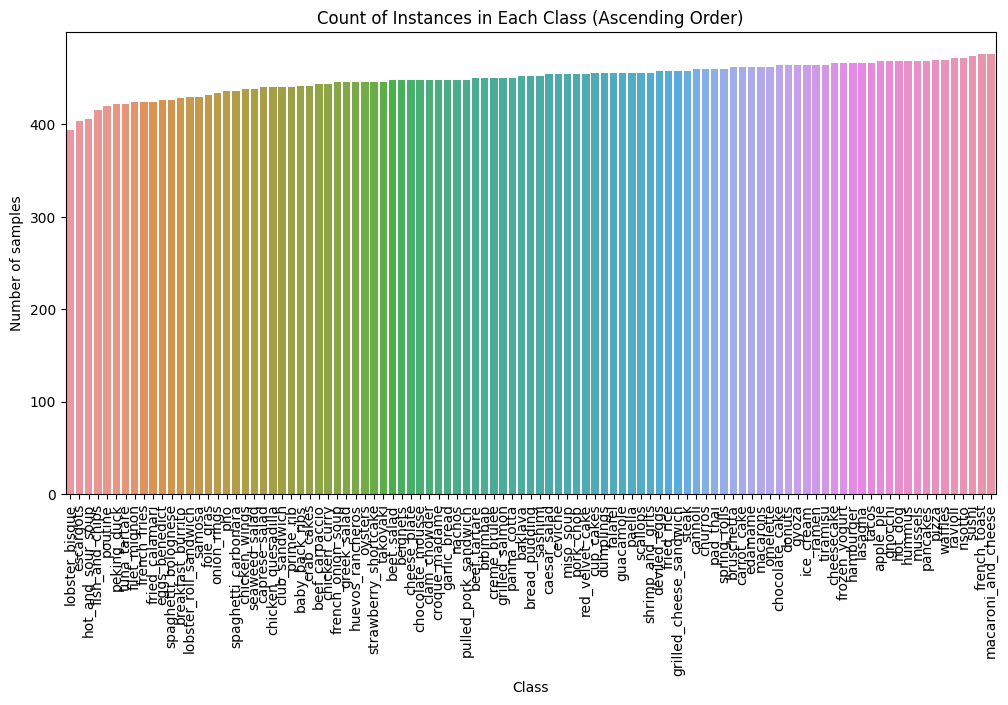

In [11]:
#  Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Sort the class labels and counts in ascending order
sorted_indices = sorted(range(len(class_counts)), key=lambda k: class_counts[k])
class_labels_sorted = [class_labels[i] for i in sorted_indices]
class_counts_sorted = [class_counts[i] for i in sorted_indices]

# Create a count plot with sorted data
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels_sorted, y=class_counts_sorted)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class (Ascending Order)')
plt.show()

# Validation

In [20]:
resnet.eval()

# Initialize lists to store the average probabilities and true labels
predicted_labels = []
true_labels = []

# Iterate over the dataloader in your testing loop
for _, images_4, labels in validation_data_loader:

    images_4 = images_4.to(device)
    logits_4 = resnet(images_4)
    logits_3 = torch.zeros_like(logits_4)

    probabilities_3 = torch.softmax(logits_3, dim=1)
    probabilities_4 = torch.softmax(logits_4, dim=1)

    avg_probabilities_batch = (probabilities_3 + probabilities_4) / 2

    predicted_labels.extend(avg_probabilities_batch.cpu().tolist())
    true_labels.extend(labels)

In [21]:
predicted_classes = torch.argmax(torch.tensor(predicted_labels), dim=1)
actual_labels = torch.tensor(true_labels)

In [22]:
accuracy = accuracy_score(actual_labels, predicted_classes)
precision = precision_score(actual_labels, predicted_classes, average='weighted')
recall = recall_score(actual_labels, predicted_classes, average='weighted')
f1 = f1_score(actual_labels, predicted_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.26804895228033104
Precision: 0.5243780294792146
Recall: 0.26804895228033104
F1-score: 0.27455993739606616


In [23]:
print(classification_report(actual_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.09      0.37      0.14       468
           1       0.19      0.53      0.28       442
           2       0.23      0.52      0.31       452
           3       0.61      0.24      0.35       444
           4       0.09      0.38      0.15       450
           5       0.83      0.02      0.04       448
           6       0.42      0.49      0.45       448
           7       0.84      0.19      0.31       450
           8       0.46      0.03      0.05       452
           9       0.43      0.29      0.35       428
          10       1.00      0.00      0.01       462
          11       0.61      0.28      0.38       454
          12       0.51      0.26      0.34       460
          13       1.00      0.03      0.05       440
          14       0.21      0.35      0.26       462
          15       0.46      0.11      0.18       454
          16       0.62      0.07      0.13       448
          17       0.33    

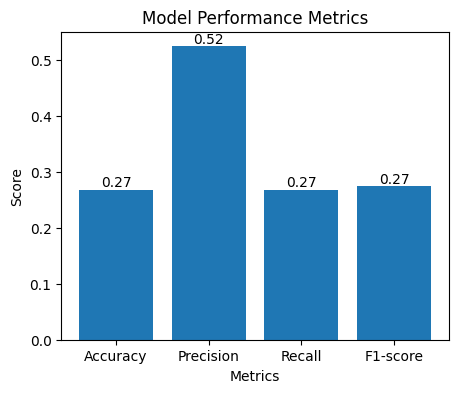

In [24]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(x, values)

# labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# scores on top of each bar
for i, bar in enumerate(bars):
    score = values[i]
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', ha='center', va='bottom')

plt.show()

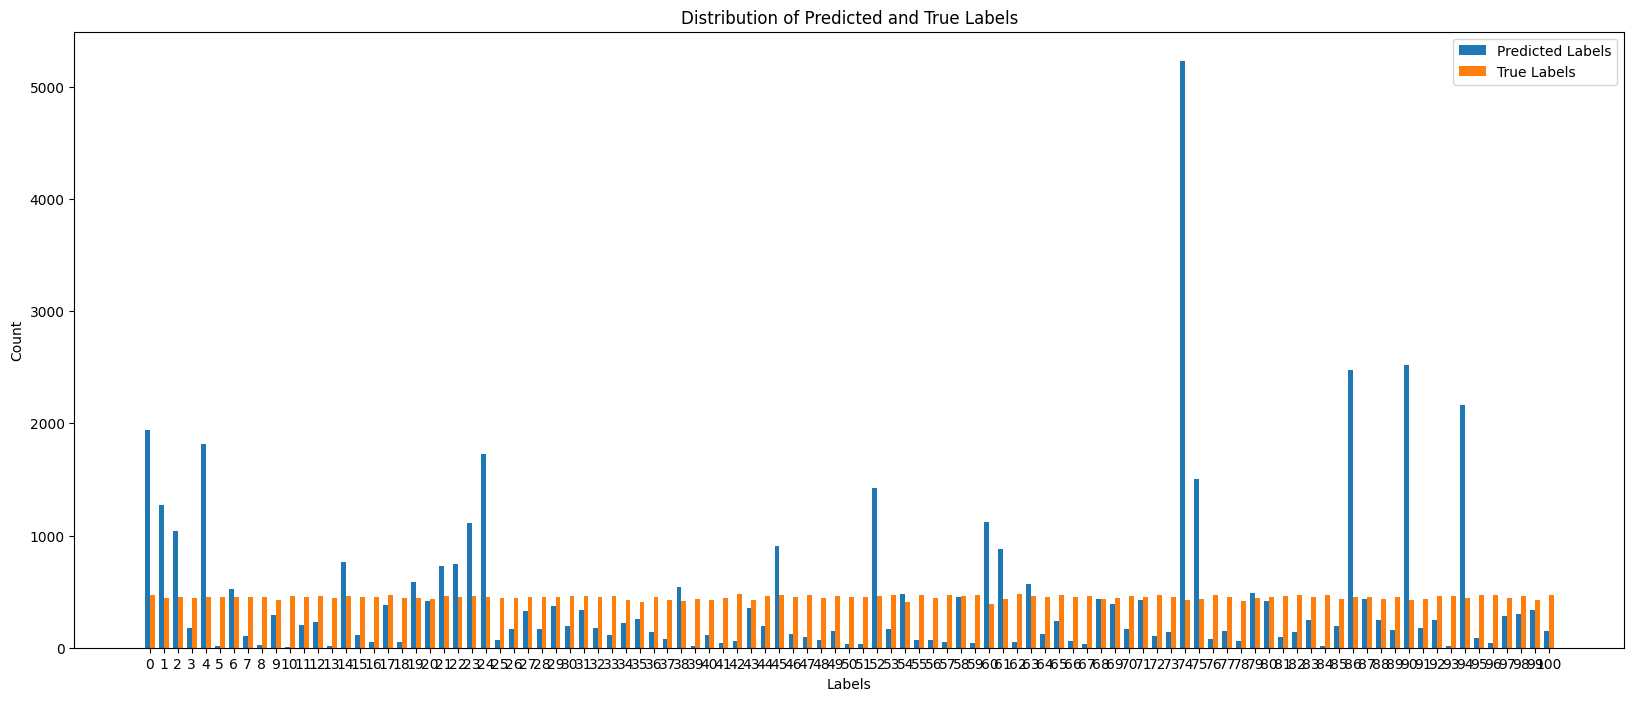

In [25]:
# Count the occurrences of each label in predicted and true labels
predicted_counts = np.bincount(predicted_classes)
true_counts = np.bincount(actual_labels)

# Get the unique labels
labels = np.unique(np.concatenate((predicted_classes, actual_labels)))

# Set the x-axis range
x = np.arange(len(labels))

# Set the width of the bars
width = 0.35

# Plot the predicted and true label counts
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(x - width/2, predicted_counts, width, label='Predicted Labels')
ax.bar(x + width/2, true_counts, width, label='True Labels')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Predicted and True Labels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()